# **Practical 2: Medical Image Analysis**
ID5220: Biomedical Imaging and Sensing

**Ensemble of pre-trained Vision Transformer (ViT) Models for Pneumonia Diagnosis from windowed chest X-rays**

### **1. Defining Problem, Evaluation Metrics and Project Structure**

* Binary classification problem
* Replicate pretrained Vision Transformer results from Nicholas Muchinguri
* Try to improve his results by applying windowing
* Build ensemble model of models trained on different windowing parameters
* Training with full data on HPC
* Will provide Loss, Accuracy, Recall, Precision, F1-Score, F2-Score, AUC, Confusion Matrices

In [ ]:
# !pip install transformers[torch]
# !pip install "accelerate>=0.26.0"
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
import shutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from transformers import pipeline, ViTForImageClassification, TrainingArguments, Trainer, ViTFeatureExtractor
import pandas as pd
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import cv2
import glob

In [ ]:
from code_mi_p2 import (
    simple_xray_loader,
    plot_pixel_intensity,
    xray_loader,
    balance_class_val,
    compare_windowed_images,
    evaluate_model,
    compute_metrics,
    train_windowing_model,
    dictionary_data_collator,
    create_trainer_for_model,
    get_continuous_predictions,
    evaluate_simple_model,
    add_image_paths_to_df,
    create_video
)

### **2. Data Exploration**

**2.1 Pixel Intensities**

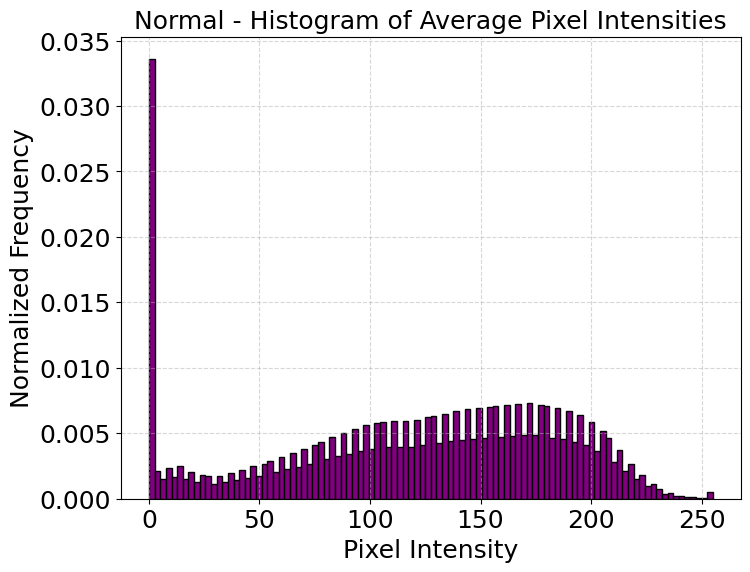

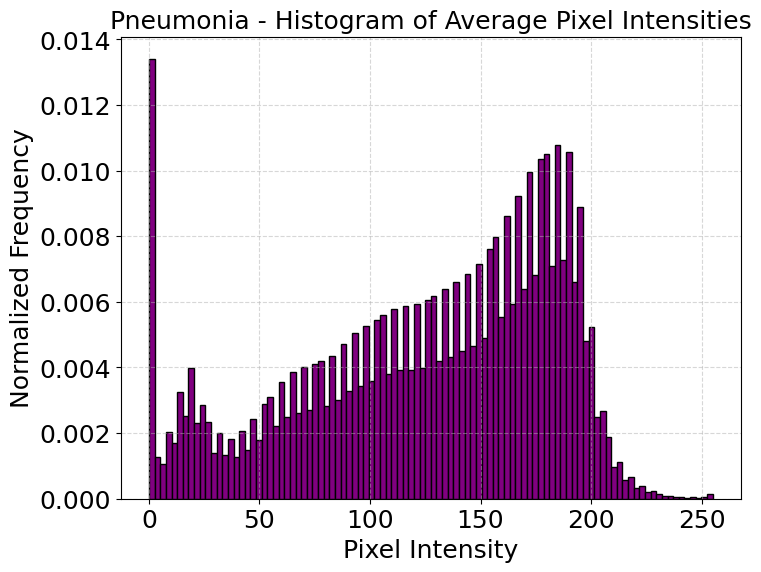

In [ ]:
small_normal_dir = "getting_started_chest_xrays/train/NORMAL"
small_pneu_dir = "getting_started_chest_xrays/train/PNEUMONIA"

# Load images from train set
normal_images = simple_xray_loader(small_normal_dir)
pneu_images = simple_xray_loader(small_pneu_dir)

# Plot histograms of average pixel intensities
plot_pixel_intensity(normal_images, title="Normal - Histogram of Average Pixel Intensities")
plot_pixel_intensity(pneu_images, title="Pneumonia - Histogram of Average Pixel Intensities")

**2.2 Experimenting with different Windowing Parameters**

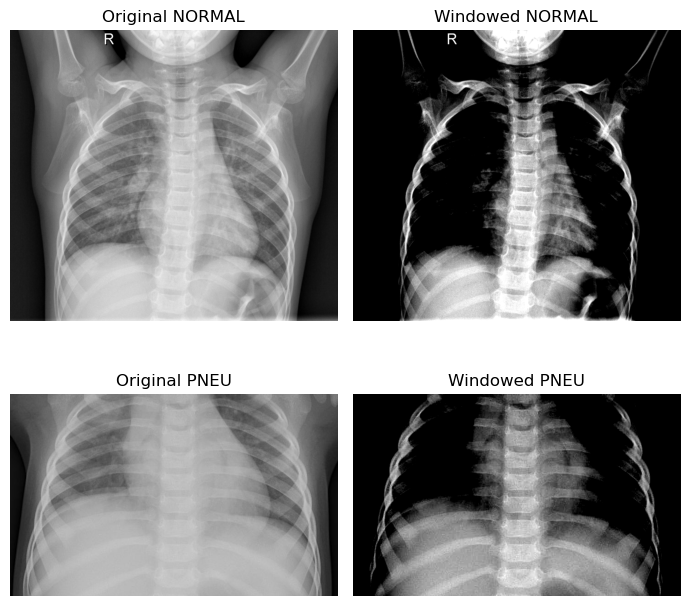

In [15]:
compare_windowed_images(
    "getting_started_chest_xrays/train/NORMAL/IM-0115-0001.jpeg",
    "getting_started_chest_xrays/train/PNEUMONIA/person1_bacteria_1.jpeg",
    150, 220
)

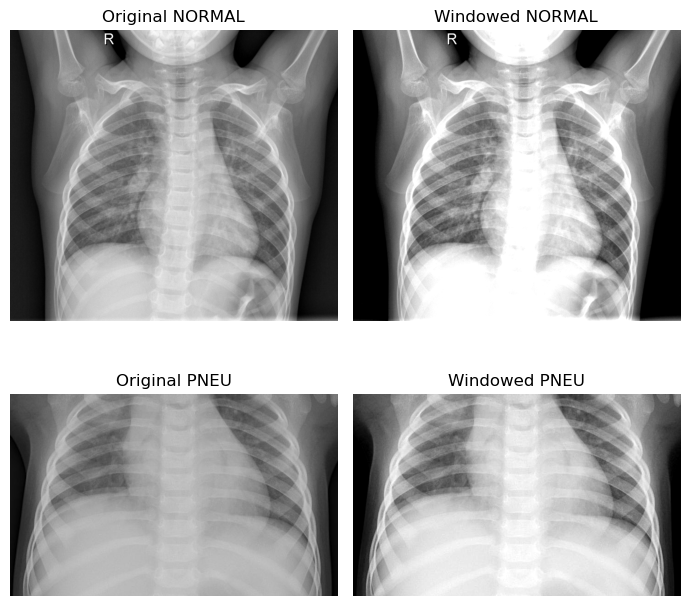

In [17]:
compare_windowed_images(
    "getting_started_chest_xrays/train/NORMAL/IM-0115-0001.jpeg",
    "getting_started_chest_xrays/train/PNEUMONIA/person1_bacteria_1.jpeg",
    30, 200
)

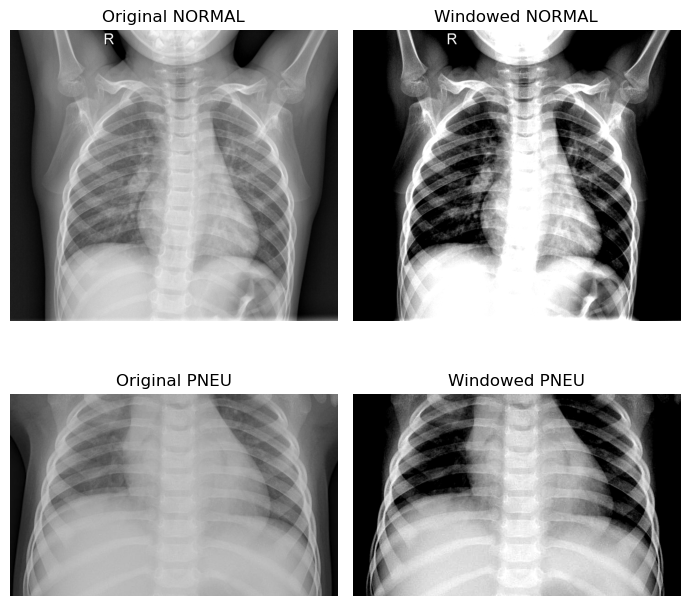

In [18]:
compare_windowed_images(
    "getting_started_chest_xrays/train/NORMAL/IM-0115-0001.jpeg",
    "getting_started_chest_xrays/train/PNEUMONIA/person1_bacteria_1.jpeg",
    100, 200
)

### **3. Data Preprocessing**

**3.1 Shift images from train to val**

Keeping in mind to group by person and only shift full people's images.

In [ ]:
# Did that for both the small and full data set

# Balance NORMAL
normal_train_dir = "chest_xray/train/NORMAL"
normal_val_dir = "chest_xray/val/NORMAL"
normal_files = [f for f in os.listdir(normal_train_dir)]
target_normal = int(len(normal_files) * 0.2)  # move 20% of NORMAL images

# print(f"\nRebalancing NORMAL: trying to move ~{target_normal} images from train to val.")
# balance_class_val(normal_train_dir, normal_val_dir, target_normal, "NORMAL")


Rebalancing NORMAL: trying to move ~268 images from train to val.
Total images in chest_xray/train/NORMAL: 1341
After moving for NORMAL: train has 1073 images, val NORMAL has 276 images.


In [ ]:
# Balance PNEUMONIA
pneu_train_dir = "chest_xray/train/PNEUMONIA"
pneu_val_dir = "chest_xray/val/PNEUMONIA"
pneu_files = [f for f in os.listdir(pneu_train_dir)]
target_pneu = int(len(pneu_files) * 0.2)  # move 20% of PNEUMONIA images

# print(f"\nRebalancing PNEUMONIA: trying to move ~{target_pneu} images from train to val.")
# balance_class_val(pneu_train_dir, pneu_val_dir, target_pneu, "PNEUMONIA")


Rebalancing PNEUMONIA: trying to move ~775 images from train to val.
Total images in chest_xray/train/PNEUMONIA: 3875
After moving for PNEUMONIA: train has 3099 images, val PNEUMONIA has 784 images.


### **4. Testing and Reproducing Nicholas Muchinguri's ViT Model**

**4.1 Verifying results from Nicholas Muchinguri (vit-finetuned-chest-xray-pneumonia)**

"This model is a fine-tuned version of google/vit-base-patch16-224-in21k on the chest-xray-pneumonia dataset. It achieves the following results on the evaluation set: Loss: 0.1271, Accuracy: 0.9551"

Training hyperparameters:
* learning_rate: 2e-05
* train_batch_size: 16
* eval_batch_size: 8
* seed: 42
* optimizer: Adam with betas=(0.9,0.999) and epsilon=1e-08
* lr_scheduler_type: linear
* num_epochs: 10



In [2]:
# Create the Hugging Face pipeline for model from Nicholas Muchinguri
nicholas_pipe = pipeline("image-classification", model="nickmuchi/vit-finetuned-chest-xray-pneumonia", top_k=2)

Device set to use mps:0


In [ ]:
# Load and Transform full Data test set without windowing
# target_size parameter resizes every image to 224×224 pixels
# rescale=1.0/255 parameter normalizes the pixel intensity values
# This was done without any further image augmentations

full_data_loaders, full_datasets_dict = xray_loader(root_dir='chest_xray', batch_size=16, num_workers=4, windowing=False)
for phase in ['train', 'val', 'test']:
    print(f"{phase.capitalize()} set: {len(full_datasets_dict[phase])} images")

Train set: 5216 images
Val set: 16 images
Test set: 624 images


In [ ]:
# Evaluate on the test sets:
print("\nEvaluating Test Set:")
test_metrics = evaluate_model(nicholas_pipe, full_data_loaders['test'], full_datasets_dict['test'].classes)

# The results validate the claimed results


Evaluating Test Set:
Loss: 0.1824
Accuracy: 0.9535
Precision: 0.9593
Recall: 0.9667
F1-Score: 0.9630
AUC: 0.9914
Confusion Matrix:
[[218  16]
 [ 13 377]]


**4.2 Reproducing Model using ViT Vision Transformer pre-trained on ImageNet-21k using image augmentation, early stopping, and save best model.**

The Vision Transformer (ViT) is a transformer encoder model (BERT-like) pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224. It was introduced in the paper An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by Dosovitskiy et al. and first released in this repository. However, the weights were converted from the timm repository by Ross Wightman, who already converted the weights from JAX to PyTorch. Credits go to him.

* pre-trained on ImageNet-21k, 14 million images and 21k classes, at a resolution of 224x224 pixels.
* transformer encoder model adapted for vision tasks
* ViT splits an image into fixed-size patches, treats each patch as a token, and processes them using the self-attention mechanism common to transformer models (similar to BERT in NLP)
* image augmentation, early stopping, and save best model were added as earlier attempts seemed to overfit


@misc{wu2020visual,
      title={Visual Transformers: Token-based Image Representation and Processing for Computer Vision}, 
      author={Bichen Wu and Chenfeng Xu and Xiaoliang Dai and Alvin Wan and Peizhao Zhang and Zhicheng Yan and Masayoshi Tomizuka and Joseph Gonzalez and Kurt Keutzer and Peter Vajda},
      year={2020},
      eprint={2006.03677},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}

@inproceedings{deng2009imagenet,
  title={Imagenet: A large-scale hierarchical image database},
  author={Deng, Jia and Dong, Wei and Socher, Richard and Li, Li-Jia and Li, Kai and Fei-Fei, Li},
  booktitle={2009 IEEE conference on computer vision and pattern recognition},
  pages={248--255},
  year={2009},
  organization={Ieee}
}

**Redundancy of 2 Evaluation Functions.** Now that I'm training the model myself and not just use the finished pipeline, i had to create another very similar evaluation function (compute_metrics).

Also when I now test on the test set using the trainer.evaluate which is more integrated than my previous approach of using my evaluate_model function and manually using the data loaders.


This is his Network Architecture


{
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "NORMAL",
    "1": "PNEUMONIA"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NORMAL": "0",
    "PNEUMONIA": "1"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "problem_type": "single_label_classification",
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.17.0"
}

**Final Evaluation Results:** {'eval_loss': 0.06602094322443008, 'eval_accuracy': 0.980188679245283, 'eval_precision': 0.9973924380704041, 'eval_recall': 0.9757653061224489, 'eval_f1': 0.9864603481624759, 'eval_auc': 0.9975922434191069, 'eval_confusion_matrix': [[274, 2], [19, 765]], 'eval_runtime': 55.6642, 'eval_samples_per_second': 19.043, 'eval_steps_per_second': 2.389, 'epoch': 8.0}

In [20]:
# Load full test data
full_data_loaders, full_datasets_dict = xray_loader(
    root_dir="chest_xray", 
    batch_size=16, 
    num_workers=4, 
    windowing=False
)

In [21]:
model_dir = "./reproduced_model3"
model = ViTForImageClassification.from_pretrained(model_dir)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_dir)

full_nicholas_repro3_trainer = Trainer(
    model=model,
    eval_dataset=full_datasets_dict["test"],
    compute_metrics=compute_metrics,
    processing_class=feature_extractor,
    data_collator=dictionary_data_collator
)

/opt/anaconda3/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# Evaluation on the test set for this model was done out of curiosity after the final ensemble model was tested on test set.

# Evaluate on test set
reproduction3_test_results = full_nicholas_repro3_trainer.evaluate()
# for full results
print("Test Set Evaluation Results:", reproduction3_test_results)

Trainer is attempting to log a value of "[[158, 76], [2, 388]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[0.9729222655296326, 0.027077743783593178], [0.9758327603340149, 0.02416715957224369], [0.9777539968490601, 0.022246064618229866], [0.9578889608383179, 0.0421111099421978], [0.9771086573600769, 0.022891268134117126], [0.9904564023017883, 0.009543574415147305], [0.9769639372825623, 0.0230360496789217], [0.9726083278656006, 0.02739165909588337], [0.8516649603843689, 0.14833499491214752], [0.9872013330459595, 0.012798638083040714], [0.9878895878791809, 0.012110386975109577], [0.9291008114814758, 0.07089919596910477], [0.9634080529212952, 0.03659192845225334], [0.9821099638938904, 0.017889995127916336], [0.022010093554854393, 0.9779899716377258], [0.9791089296340942, 0.02089102193713188], [0.005581071134656668, 0.99441897869

Evaluation metrics:
accuracy: 0.875
precision: 0.8362068965517241
recall: 0.9948717948717949
f1: 0.9086651053864169
auc: 0.9741617357001973
confusion_matrix: [[158, 76], [2, 388]]
Test Set Evaluation Results: {'eval_loss': 0.4941462576389313, 'eval_model_preparation_time': 0.0056, 'eval_accuracy': 0.875, 'eval_precision': 0.8362068965517241, 'eval_recall': 0.9948717948717949, 'eval_f1': 0.9086651053864169, 'eval_auc': 0.9741617357001973, 'eval_confusion_matrix': [[158, 76], [2, 388]], 'eval_probabilities': [[0.9729222655296326, 0.027077743783593178], [0.9758327603340149, 0.02416715957224369], [0.9777539968490601, 0.022246064618229866], [0.9578889608383179, 0.0421111099421978], [0.9771086573600769, 0.022891268134117126], [0.9904564023017883, 0.009543574415147305], [0.9769639372825623, 0.0230360496789217], [0.9726083278656006, 0.02739165909588337], [0.8516649603843689, 0.14833499491214752], [0.9872013330459595, 0.012798638083040714], [0.9878895878791809, 0.012110386975109577], [0.9291008

### **5. Ensemble Model with Windowed Images**

**5.1 Load 3 trained models**

In [ ]:
# Model 1: No windowing
trainer_no_window, datasets_no_window = create_trainer_for_model(
    root_dir="chest_xray",
    model_dir="./reproduced_model3",
    phase="train",
    windowing=False
)

# Model 2: windowing with lower=150, upper=200
trainer_150_200, datasets_150_200 = create_trainer_for_model(
    root_dir="chest_xray",
    model_dir="./model_150_200",
    phase="train",
    windowing=True,
    lower=150,
    upper=200
)

# Model 3: windowing with lower=30, upper=200
trainer_30_200, datasets_30_200 = create_trainer_for_model(
    root_dir="chest_xray",
    model_dir="./model_30_200",
    phase="train",
    windowing=True,
    lower=30,
    upper=200
)



/opt/anaconda3/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


**5.2 Turn Model's predictions into train, val, and test sets (df) to train second stage classifier on**

In [ ]:
# Get predictions for each model on the TRAIN set
# Use positive probability (column index 1) from the softmax outputs

preds_no_window_train = get_continuous_predictions(trainer_no_window, datasets_no_window["train"])[:, 1]
preds_150_200_train = get_continuous_predictions(trainer_150_200, datasets_150_200["train"])[:, 1]
preds_30_200_train = get_continuous_predictions(trainer_30_200, datasets_30_200["train"])[:, 1]

target_train = np.array(datasets_no_window["train"].targets)

# Create Pandas DataFrame for training
train_df = pd.DataFrame({
    "pred_no_window": preds_no_window_train,
    "pred_150_200": preds_150_200_train,
    "pred_30_200": preds_30_200_train,
    "target": target_train
})

print("First 10 rows of the training DataFrame:")
print(train_df.head(10))

Evaluation metrics:
accuracy: 0.9923298178331735
precision: 0.9957969608794051
recall: 0.9938689899967732
f1: 0.9948320413436692
auc: 0.999517025454202
confusion_matrix: [[1060, 13], [19, 3080]]


Evaluation metrics:
accuracy: 0.9863374880153404
precision: 0.9878127004490058
recall: 0.9938689899967732
f1: 0.990831590799421
auc: 0.9985213039590981
confusion_matrix: [[1035, 38], [19, 3080]]


Evaluation metrics:
accuracy: 0.9918504314477469
precision: 0.9907140569964777
recall: 0.9983865763149403
f1: 0.994535519125683
auc: 0.999864069430448
confusion_matrix: [[1044, 29], [5, 3094]]
First 10 rows of the training DataFrame:
   pred_no_window  pred_150_200  pred_30_200  target
0        0.007761      0.007487     0.004414       0
1        0.006264      0.006187     0.003872       0
2        0.007572      0.008377     0.004300       0
3        0.044038      0.010890     0.025786       0
4        0.014721      0.034934     0.233217       0
5        0.007414      0.006182     0.003825       0
6        0.023942      0.007120     0.004743       0
7        0.022854      0.150443     0.175834       0
8        0.007884      0.006467     0.004046       0
9        0.010856      0.010733     0.004728       0


In [9]:
train_df.to_csv('ensemble_train.csv', index=False)

In [ ]:
# Do the same for the validation set

preds_no_window_val = get_continuous_predictions(trainer_no_window, datasets_no_window["val"])[:, 1]
preds_150_200_val = get_continuous_predictions(trainer_150_200, datasets_150_200["val"])[:, 1]
preds_30_200_val = get_continuous_predictions(trainer_30_200, datasets_30_200["val"])[:, 1]

target_val = np.array(datasets_no_window["val"].targets)

val_df = pd.DataFrame({
    "pred_no_window": preds_no_window_val,
    "pred_150_200": preds_150_200_val,
    "pred_30_200": preds_30_200_val,
    "target": target_val
})

print("First 10 rows of the validation DataFrame:")
val_df.head(10)

Evaluation metrics:
accuracy: 0.980188679245283
precision: 0.9973924380704041
recall: 0.9757653061224489
f1: 0.9864603481624759
auc: 0.9976892931085477
confusion_matrix: [[274, 2], [19, 765]]


Evaluation metrics:
accuracy: 0.970754716981132
precision: 0.9796178343949045
recall: 0.9808673469387755
f1: 0.9802421924792861
auc: 0.9953323720792664
confusion_matrix: [[260, 16], [15, 769]]


Evaluation metrics:
accuracy: 0.9811320754716981
precision: 0.9835443037974684
recall: 0.9910714285714286
f1: 0.9872935196950444
auc: 0.9975598935226264
confusion_matrix: [[263, 13], [7, 777]]
First 10 rows of the validation DataFrame:


,pred_no_window,pred_150_200,pred_30_200,target
0,0.007045,0.006613,0.004174,0
1,0.022100,0.007854,0.413585,0
2,0.006366,0.006057,0.003980,0
3,0.027894,0.015705,0.014298,0
4,0.008106,0.006189,0.004194,0
5,0.006783,0.006977,0.004206,0
6,0.032075,0.019568,0.043373,0
7,0.015529,0.006504,0.007784,0
8,0.014550,0.010123,0.024983,0
9,0.007680,0.007086,0.003991,0


In [10]:
val_df.to_csv('ensemble_val.csv', index=False)

In [ ]:
# Do the same for the test set
# The functions unfortunately here print the results of the individual models on the test set.
# I collapsed the output, so that i wouldn't see them and have snooping bias.

preds_no_window_test = get_continuous_predictions(trainer_no_window, datasets_no_window["test"])[:, 1]
preds_150_200_test = get_continuous_predictions(trainer_150_200, datasets_150_200["test"])[:, 1]
preds_30_200_test = get_continuous_predictions(trainer_30_200, datasets_30_200["test"])[:, 1]

target_test = np.array(datasets_no_window["test"].targets)

test_df = pd.DataFrame({
    "pred_no_window": preds_no_window_test,
    "pred_150_200": preds_150_200_test,
    "pred_30_200": preds_30_200_test,
    "target": target_test
})

test_df.to_csv('ensemble_test.csv', index=False)

Evaluation metrics:
accuracy: 0.875
precision: 0.8362068965517241
recall: 0.9948717948717949
f1: 0.9086651053864169
auc: 0.9741617357001973
confusion_matrix: [[158, 76], [2, 388]]


Evaluation metrics:
accuracy: 0.8092948717948718
precision: 0.7672583826429981
recall: 0.9974358974358974
f1: 0.867335562987737
auc: 0.9551008108700417
confusion_matrix: [[116, 118], [1, 389]]


Evaluation metrics:
accuracy: 0.8285256410256411
precision: 0.7858585858585858
recall: 0.9974358974358974
f1: 0.8790960451977401
auc: 0.9663214990138067
confusion_matrix: [[128, 106], [1, 389]]


**5.3 Train simple second stage classifiers on the DFs**

In [59]:
# Import saved DFs
train_df = pd.read_csv("ensemble_train.csv")
validation_df = pd.read_csv("ensemble_val.csv")
test_df = pd.read_csv("ensemble_test.csv")

In [60]:
# Prepare for training
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']

X_val = validation_df.drop('target', axis=1)
y_val = validation_df['target']

X_test = test_df.drop('target', axis=1)
y_test = test_df['target']

Logistic Regression Performance:
Accuracy:  0.977
Precision: 0.987
Recall:    0.982
F1 Score:  0.985
F2 Score:  0.983



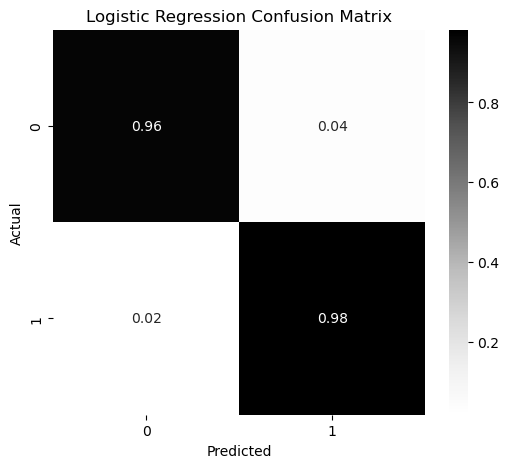

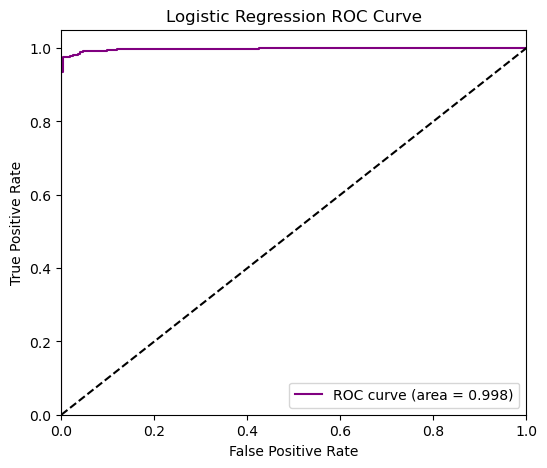

In [ ]:
# Logistic Regression
logistic_regression_model = LogisticRegression(random_state=5220, max_iter=1000)
logistic_regression_model.fit(X_train, y_train)
y_pred_lr = logistic_regression_model.predict(X_val)

evaluate_simple_model(logistic_regression_model, X_val, y_val, title="Logistic Regression")

SVM Classifier Performance:
Accuracy:  0.977
Precision: 0.986
Recall:    0.983
F1 Score:  0.985
F2 Score:  0.984



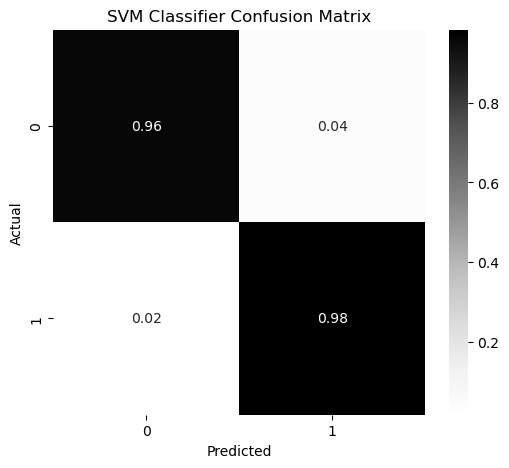

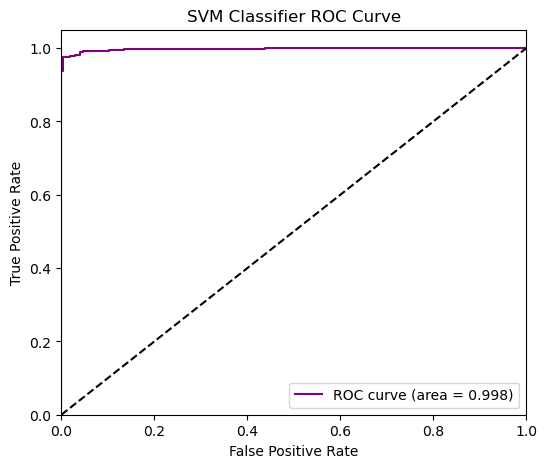

In [ ]:
# SVM Classifier
svm_model = SGDClassifier(random_state=5220)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)

evaluate_simple_model(svm_model, X_val, y_val, title="SVM Classifier")


Random Forest Performance:
Accuracy:  0.976
Precision: 0.990
Recall:    0.978
F1 Score:  0.984
F2 Score:  0.981



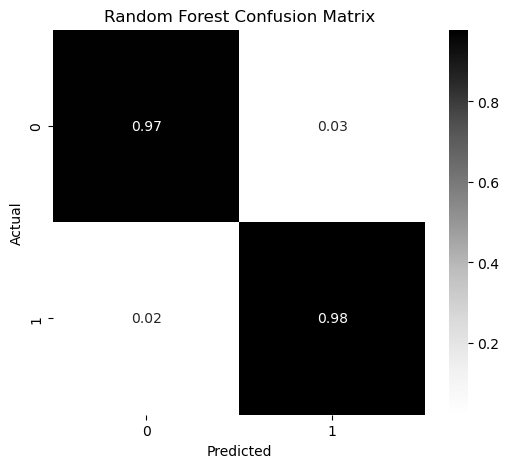

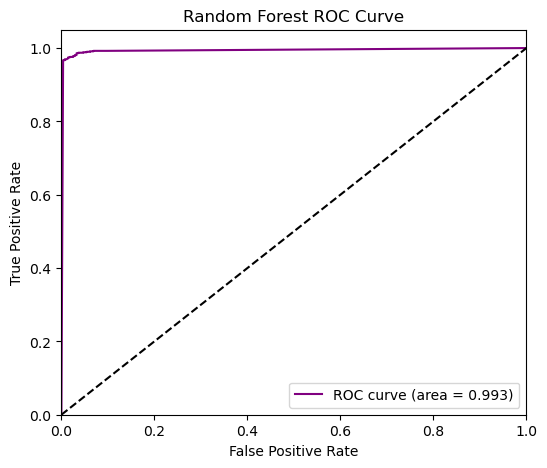

In [ ]:
# Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=5,
    random_state=5220,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

# evaluate_simple_model(rf_model, X_test, y_test, title="Random Forest")
evaluate_simple_model(rf_model, X_val, y_val, title="Random Forest")

**5.4 Final Test on Test Set**


Final Evaluation on Test Set

Final Evaluation - Random Forest Performance:
Accuracy:  0.857
Precision: 0.816
Recall:    0.997
F1 Score:  0.897
F2 Score:  0.955



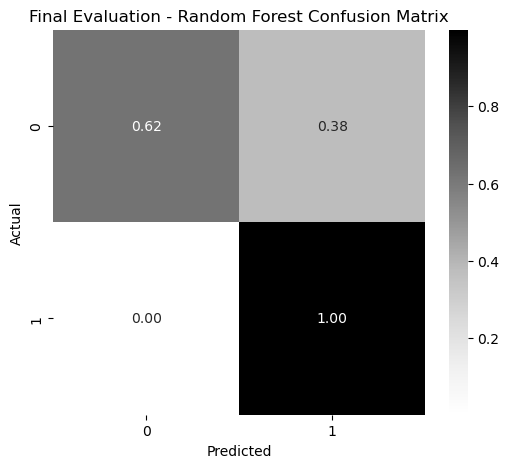

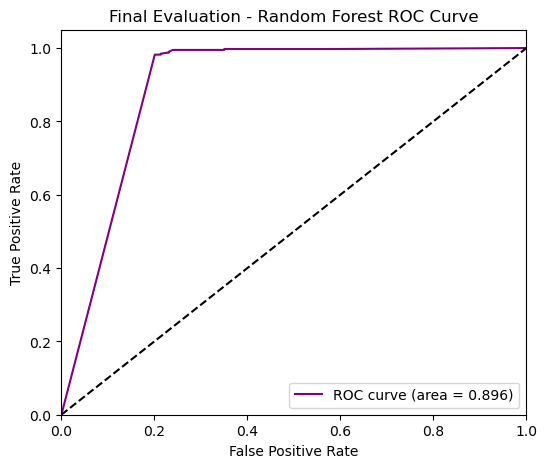

In [62]:
print("\nFinal Evaluation on Test Set\n")
evaluate_simple_model(rf_model, X_test, y_test, title="Final Evaluation - Random Forest")

### **6. Prediction Video**

**6.1 Creating DF with all required columns for video**

In [ ]:
X_test["pred"] = rf_model.predict(X_test)
X_test.head(5)

,pred_no_window,pred_150_200,pred_30_200,pred
0,0.027078,0.927565,0.007587,0
1,0.024167,0.911757,0.036553,0
2,0.022246,0.560199,0.022989,0
3,0.042111,0.931325,0.015886,0
4,0.022891,0.160081,0.008563,0


In [36]:
y_test.head(5)

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [ ]:
# Adding target
df_test = pd.DataFrame(X_test)
df_test['target'] = y_test
df_test.head(5)

,pred_no_window,pred_150_200,pred_30_200,pred,target
0,0.027078,0.927565,0.007587,0,0
1,0.024167,0.911757,0.036553,0,0
2,0.022246,0.560199,0.022989,0,0
3,0.042111,0.931325,0.015886,0,0
4,0.022891,0.160081,0.008563,0,0


In [ ]:
# Adding image path
df_test_with_paths = add_image_paths_to_df(df_test, "chest_xray", "test")
df_test_with_paths.head(5)

Looking in: chest_xray/test


,pred_no_window,pred_150_200,pred_30_200,pred,target,image_path
0,0.027078,0.927565,0.007587,0,0,chest_xray/test/NORMAL/IM-0031-0001.jpeg
1,0.024167,0.911757,0.036553,0,0,chest_xray/test/NORMAL/IM-0025-0001.jpeg
2,0.022246,0.560199,0.022989,0,0,chest_xray/test/NORMAL/NORMAL2-IM-0272-0001.jpeg
3,0.042111,0.931325,0.015886,0,0,chest_xray/test/NORMAL/NORMAL2-IM-0102-0001.jpeg
4,0.022891,0.160081,0.008563,0,0,chest_xray/test/NORMAL/NORMAL2-IM-0229-0001.jpeg


**6.2 Creating Video**

In [ ]:
# All helper functions in script
output_video_filename = "predictions_video.mp4"
create_video(df_test_with_paths, output_video_filename, fps=1)

Determined frame size: (1949, 1632)
Processing frame 0: chest_xray/test/NORMAL/IM-0031-0001.jpeg
Processing frame 1: chest_xray/test/NORMAL/IM-0025-0001.jpeg
Processing frame 2: chest_xray/test/NORMAL/NORMAL2-IM-0272-0001.jpeg
Processing frame 3: chest_xray/test/NORMAL/NORMAL2-IM-0102-0001.jpeg
Processing frame 4: chest_xray/test/NORMAL/NORMAL2-IM-0229-0001.jpeg
Processing frame 5: chest_xray/test/NORMAL/NORMAL2-IM-0315-0001.jpeg
Processing frame 6: chest_xray/test/NORMAL/NORMAL2-IM-0123-0001.jpeg
Processing frame 7: chest_xray/test/NORMAL/NORMAL2-IM-0301-0001.jpeg
Processing frame 8: chest_xray/test/NORMAL/NORMAL2-IM-0246-0001-0002.jpeg
Processing frame 9: chest_xray/test/NORMAL/IM-0010-0001.jpeg
Processing frame 10: chest_xray/test/NORMAL/IM-0046-0001.jpeg
Processing frame 11: chest_xray/test/NORMAL/NORMAL2-IM-0357-0001.jpeg
Processing frame 12: chest_xray/test/NORMAL/NORMAL2-IM-0027-0001.jpeg
Processing frame 13: chest_xray/test/NORMAL/NORMAL2-IM-0033-0001.jpeg
Processing frame 14: 